# 晶体图卷积神经网络CGCNN

In [1]:
# 导入需要的第三方库
from __future__ import print_function, division
import csv
import functools
import json
import os
import random
import shutil
import time
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams["font.sans-serif"] = ["SimHei"] # 解决中文字符乱码的问题
plt.rcParams["axes.unicode_minus"] = False # 正常显示负号

import torch
import torch.nn as nn
import torch.optim as optim

from IPython import display
from sklearn import metrics
from torch.autograd import Variable
from torch.optim.lr_scheduler import MultiStepLR

from pymatgen.core.structure import Structure
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.dataloader import default_collate
from torch.utils.data.sampler import SubsetRandomSampler

## 一、数据准备

根据mp-ids-27430.csv从Materials Project数据库下载

①结构文件：id.cif

②属性文件：id_prop.csv

到dataset目录，共获得19627个结构文件。

In [2]:
from mp_api.client import MPRester
from pymatgen.io.cif import CifWriter

API_KEY='G4m0QEHjNGUE6vDXoa70jDErWmAI7BE4' # 本人的密匙
mpr = MPRester(API_KEY) # 调用Materials Project数据库接口
"""
查看可用属性字段列表，这里只展示前5个，我们可以从中选取属性指定为target。
除本次实验预测的形成能外，还可以预测带隙、体模量、剪切模量、费米能级、总能、泊松比等材料属性。
"""
list_of_available_fields = mpr.summary.available_fields
list_of_available_fields[:5]

['builder_meta', 'nsites', 'elements', 'nelements', 'composition']

In [ ]:
with open('./mp-ids-27430.csv') as f:
    reader = csv.reader(f)
    mp_ids = [row[0] for row in reader]
for mp_id in mp_ids:
    # 获取id_num
    id_num = mp_id.split('-')[1]
    try:
        # 指定target。
        target = mpr.summary.search(material_ids=[mp_id], fields=["formation_energy_per_atom"])[0].formation_energy_per_atom
        # 下载cif结构文件
        structure = mpr.get_structure_by_material_id(mp_id)
        cif_writer = CifWriter(structure)
        cif_writer.write_file("./dataset/"+id_num+".cif")
    except:
        continue
    # 在id_prop.csv文件中输出id_num和target
    with open('./dataset/id_prop.csv', 'a+', newline='') as f:
        writer = csv.writer(f)
        writer.writerows([[id_num, target]])

## 二、模型训练

### 2.1 从cif结构文件中获取数据

In [2]:
class AtomInitializer(object):
    """初始化原子向量"""
    def __init__(self, atom_types):
        self.atom_types = set(atom_types)
        self._embedding = {}

    def get_atom_fea(self, atom_type):
        assert atom_type in self.atom_types
        return self._embedding[atom_type]

    def load_state_dict(self, state_dict):
        self._embedding = state_dict
        self.atom_types = set(self._embedding.keys())
        self._decodedict = {idx: atom_type for atom_type, idx in self._embedding.items()}

    def state_dict(self):
        return self._embedding

    def decode(self, idx):
        if not hasattr(self, '_decodedict'):
            self._decodedict = {idx: atom_type for atom_type, idx in self._embedding.items()}
        return self._decodedict[idx]

class AtomCustomJSONInitializer(AtomInitializer): 
    """
    使用atom_init.json文件初始化原子特征向量。
    返回一个字典，键是元素序号（从1到100），值是元素对应的初始原子向量（92维）。
    --------------------------------------------
    elem_embedding_file是atom_init.json文件的路径
    """
    def __init__(self, elem_embedding_file):
        with open(elem_embedding_file) as f:
            elem_embedding = json.load(f) 
        elem_embedding = {int(key): value for key, value in elem_embedding.items()}
        atom_types = set(elem_embedding.keys())
        super(AtomCustomJSONInitializer, self).__init__(atom_types)
        for key, value in elem_embedding.items():
            self._embedding[key] = np.array(value, dtype=float)

class GaussianDistance(object):
    """
    使用一维高斯函数exp(-(x-μ)^2/σ^2)展开原子间距（即初始边特征向量），单位是埃（1E-10米）。
    展开后边特征向量的维度是41维。
    """
    def __init__(self, dmin, dmax, step, var=None):
        assert dmin < dmax
        assert dmax - dmin > step
        self.filter = np.arange(dmin, dmax+step, step)
        if var is None:
            var = step
        self.var = var

    def expand(self, distances):
        return np.exp(-(distances[..., np.newaxis] - self.filter)**2 / self.var**2)

class CIFData(Dataset):
    """
    CIFData是Dataset的封装，Dataset应具有以下目录结构：
    根目录
    ├─ id_prop.csv：csv文件，第一列记录晶体的ID，第二列记录target值。
    ├─ atom_init.json：json文件，用于存储每个元素的初始化向量。
    ├─ ID.cif：cif文件，记录晶体结构信息，ID与id_prop.csv唯一对应。
    ├─ ...    
    ----------------------------------
    root_dir：根目录路径。
    max_num_nbr：最大近邻原子数，默认是12。
    radius：截止半径，默认是8埃。
    dmin：构造GaussianDistance的最小距离，默认是0埃。
    step：构造GaussianDistance的步长，默认是0.2埃。
    random_seed：打乱数据集的随机数种子。
    ----------------------------------
    atom_fea：原子特征矩阵，默认维度是(n_i, 92)，n_i是晶胞原子数。
    nbr_fea：边特征矩阵，默认维度是(n_i, 12, 41)。
    nbr_fea_idx：原子近邻矩阵，默认维度是(n_i, 12)，张量的数据类型是int64。
    target：目标属性，维度是(1, )。
    cif_id：打乱后的晶体ID。
    """
    def __init__(self, root_dir, max_num_nbr=12, radius=8, dmin=0, step=0.2, random_seed=123):
        # 主要任务是构建路径列表和标签列表。
        self.root_dir = root_dir
        self.max_num_nbr, self.radius = max_num_nbr, radius
        assert os.path.exists(root_dir), 'root_dir does not exist!'
        id_prop_file = os.path.join(self.root_dir, 'id_prop.csv')
        assert os.path.exists(id_prop_file), 'id_prop.csv does not exist!'
        with open(id_prop_file) as f:
            reader = csv.reader(f)
            self.id_prop_data = [row for row in reader]
        random.seed(random_seed)
        random.shuffle(self.id_prop_data)
        atom_init_file = os.path.join(self.root_dir, 'atom_init.json')
        assert os.path.exists(atom_init_file), 'atom_init.json does not exist!'
        self.ari = AtomCustomJSONInitializer(atom_init_file) # 调用AtomCustomJSONInitializer类
        self.gdf = GaussianDistance(dmin=dmin, dmax=self.radius, step=step) # 调用GaussianDistance类

    def __len__(self):
        return len(self.id_prop_data)

    @functools.lru_cache(maxsize=None)  # Cache loaded structures
    def __getitem__(self, idx):
        # 完成所有的预处理操作。idx是列表索引，返回模型的输入和标签。
        cif_id, target = self.id_prop_data[idx]
        crystal = Structure.from_file(os.path.join(self.root_dir, cif_id+'.cif'))
        atom_fea = np.vstack([self.ari.get_atom_fea(crystal[i].specie.number) for i in range(len(crystal))])
        atom_fea = torch.Tensor(atom_fea)
        all_nbrs = crystal.get_all_neighbors(self.radius, include_index=True)
        all_nbrs = [sorted(nbrs, key=lambda x: x[1]) for nbrs in all_nbrs]
        nbr_fea_idx, nbr_fea = [], []
        for nbr in all_nbrs:
            if len(nbr) < self.max_num_nbr:
                warnings.warn('{} not find enough neighbors to build graph. '
                              'If it happens frequently, consider increase radius.'.format(cif_id))
                nbr_fea_idx.append(list(map(lambda x: x[2], nbr)) + [0] * (self.max_num_nbr - len(nbr)))
                nbr_fea.append(list(map(lambda x: x[1], nbr)) + [self.radius + 1.] * (self.max_num_nbr - len(nbr)))
            else:
                nbr_fea_idx.append(list(map(lambda x: x[2], nbr[:self.max_num_nbr])))
                nbr_fea.append(list(map(lambda x: x[1], nbr[:self.max_num_nbr])))
        nbr_fea_idx, nbr_fea = np.array(nbr_fea_idx), np.array(nbr_fea)
        nbr_fea = self.gdf.expand(nbr_fea)
        atom_fea = torch.Tensor(atom_fea)
        nbr_fea = torch.Tensor(nbr_fea)
        nbr_fea_idx = torch.LongTensor(nbr_fea_idx)
        target = torch.Tensor([float(target)])
        return (atom_fea, nbr_fea, nbr_fea_idx), target, cif_id

In [3]:
root_dir = './dataset/'
# root_dir = './sample-regression/' # 用于测试的小数据集，包含10条虚拟数据。
dataset = CIFData(root_dir)

### 2.2 数据展示

In [4]:
(atom_fea, nbr_fea, nbr_fea_idx), target, cif_id = dataset.__getitem__(idx=1)
print("cif_id={};\nn_i={};\ntarget={} eV/atom;\natom_fea.size = {};\nnbr_fea.size = {};\nnbr_fea_idx.size = {};"\
      .format(cif_id, len(atom_fea), target.item(), list(atom_fea.shape), list(nbr_fea.shape), list(nbr_fea_idx.shape)))

cif_id=643829;
n_i=28;
target=-2.8293421268463135 eV/atom;
atom_fea.size = [28, 92];
nbr_fea.size = [28, 12, 41];
nbr_fea_idx.size = [28, 12];


In [5]:
# 查看晶体结构信息
crystal = Structure.from_file('{}{}.cif'.format(root_dir, cif_id))
crystal

Structure Summary
Lattice
    abc : 4.407307 7.073604999999999 9.28883328
 angles : 50.07367648999998 90.0 90.0
 volume : 222.07375342460034
      A : 4.407307 0.0 2.698697205204862e-16
      B : -3.3215715936308137e-16 5.42453807243594 4.539854006101734
      C : 0.0 0.0 9.28883328
    pbc : True True True
PeriodicSite: Al (2.0849, 3.4765, 8.1513) [0.4731, 0.6409, 0.5643]
PeriodicSite: Al (0.1187, 3.4765, 3.5069) [0.0269, 0.6409, 0.0643]
PeriodicSite: Al (2.3224, 1.9480, 5.6774) [0.5269, 0.3591, 0.4357]
PeriodicSite: Al (4.2886, 1.9480, 10.3218) [0.9731, 0.3591, 0.9357]
PeriodicSite: Si (2.1023, 4.9167, 5.7913) [0.4770, 0.9064, 0.1805]
PeriodicSite: Si (0.1014, 4.9167, 10.4357) [0.0230, 0.9064, 0.6805]
PeriodicSite: Si (2.3050, 0.5078, 8.0374) [0.5230, 0.0936, 0.8195]
PeriodicSite: Si (4.3060, 0.5078, 3.3930) [0.9770, 0.0936, 0.3195]
PeriodicSite: H (4.2589, 3.4622, 5.8027) [0.9663, 0.6382, 0.3128]
PeriodicSite: H (2.3521, 3.4622, 10.4471) [0.5337, 0.6382, 0.8128]
PeriodicSite: H (0.1

In [6]:
# 查看晶胞中心原子的原子序数，及其在晶胞中对应的编号
idx = []
for i in range(len(crystal)):
    idx.append([crystal[i].specie.number, i])
idx

[[13, 0],
 [13, 1],
 [13, 2],
 [13, 3],
 [14, 4],
 [14, 5],
 [14, 6],
 [14, 7],
 [1, 8],
 [1, 9],
 [1, 10],
 [1, 11],
 [8, 12],
 [8, 13],
 [8, 14],
 [8, 15],
 [8, 16],
 [8, 17],
 [8, 18],
 [8, 19],
 [8, 20],
 [8, 21],
 [8, 22],
 [8, 23],
 [8, 24],
 [8, 25],
 [8, 26],
 [8, 27]]

In [7]:
# 编号0中心原子对应的初始原子特征向量
AtomCustomJSONInitializer('{}atom_init.json'.format(root_dir)).get_atom_fea(crystal[0].specie.number)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0.])

In [8]:
# 截断半径设为8埃时，编号0中心原子的前12个最近邻原子在晶胞中对应的编号
all_nbrs = crystal.get_all_neighbors(8, include_index=True)
all_nbrs = [sorted(nbrs, key=lambda x: x[1]) for nbrs in all_nbrs]
nbr = all_nbrs[0]
nbr_fea_idx = list(map(lambda x: x[2], nbr[:12]))
nbr_fea_idx # 与第一个中心原子相连的端点原子

[17, 26, 20, 14, 22, 25, 9, 10, 4, 10, 2, 6]

In [9]:
# 截断半径设为8埃时，编号0中心原子与前12个最近邻原子的原子间距，即未经过GaussianDistance处理的初始边特征向量，维度是(12,)
nbr_fea = np.array((list(map(lambda x: x[1], nbr[:12]))))
nbr_fea.shape

(12,)

In [10]:
# 经过GaussianDistance处理后的边特征向量，维度变为(12, 41)
nbr_fea = GaussianDistance(dmin=0, dmax=8, step=0.2).expand(nbr_fea)
nbr_fea.shape

(12, 41)

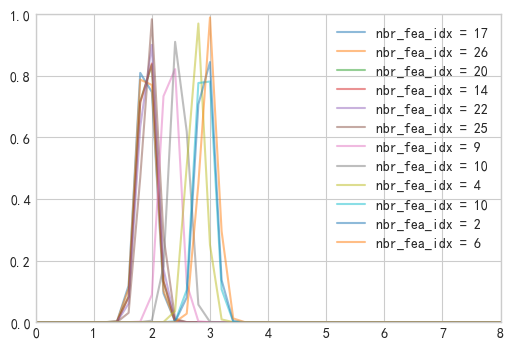

In [11]:
# 可视化GaussianDistance处理
def g(x, u):
    return np.exp(-np.power((x-u),2) / 0.04)
x = np.arange(0, 8.2, 0.2)
plt.figure(figsize=(6, 4))
for i in range(12):
    y = nbr_fea[i]
    plt.plot(x, y, label="nbr_fea_idx = "+str(nbr_fea_idx[i]), alpha=0.5)
plt.xlim(0, 8)
plt.ylim(0, 1)
plt.tick_params(bottom=False, top=False, left=False, right=False)
plt.legend()
plt.show()

### 2.3 数据集划分

对于不同的晶体结构，其晶胞原子数可能不同，同时每个中心原子考虑的最近邻原子数也可能不同，因此不能使用Dataloader默认的collate_fn函数。

In [12]:
def collate_pool(dataset):
    """
    手动将抽取出的样本堆叠起来的函数。
    输入是一个CIFData类，返回一个batch_size
    """
    batch_atom_fea, batch_nbr_fea, batch_nbr_fea_idx, crystal_atom_idx, batch_target, batch_cif_ids = [], [], [], [], [], []
    base_idx = 0
    for i, ((atom_fea, nbr_fea, nbr_fea_idx), target, cif_id) in enumerate(dataset):
        n_i = atom_fea.shape[0]
        batch_atom_fea.append(atom_fea)
        batch_nbr_fea.append(nbr_fea)
        batch_nbr_fea_idx.append(nbr_fea_idx+base_idx)
        new_idx = torch.LongTensor(np.arange(n_i)+base_idx)
        crystal_atom_idx.append(new_idx)
        batch_target.append(target)
        batch_cif_ids.append(cif_id)
        base_idx += n_i
    return (torch.cat(batch_atom_fea, dim=0), torch.cat(batch_nbr_fea, dim=0), torch.cat(batch_nbr_fea_idx, dim=0), crystal_atom_idx), torch.stack(batch_target, dim=0), batch_cif_ids

例如将idx=1的晶体和idx=2的晶体堆叠在一起，注意堆叠时crystal_atom_idx是继承的。

In [13]:
crystal_list = [dataset.__getitem__(idx=1), dataset.__getitem__(idx=2)]
(batch_atom_fea, batch_nbr_fea, batch_nbr_fea_idx, crystal_atom_idx), batch_target, batch_cif_ids= collate_pool(crystal_list)
crystal_atom_idx

[tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 tensor([28, 29, 30, 31])]

In [ ]:
def get_train_val_test_loader(dataset, collate_fn=default_collate, batch_size=64, train_ratio=None, val_ratio=0.1, test_ratio=0.1, return_test=False, num_workers=0, pin_memory=False):
    """将数据集划分为训练集、验证集和测试集的函数。"""
    total_size = len(dataset)
    if train_ratio is None:
        assert val_ratio + test_ratio < 1
        train_ratio = 1 - val_ratio - test_ratio
        print(f'[Warning] train_ratio is None, using 1 - val_ratio - test_ratio = {train_ratio} as training data.')
    else:
        assert train_ratio + val_ratio + test_ratio <= 1
    indices = list(range(total_size))
    train_size = int(train_ratio * total_size)
    test_size = int(test_ratio * total_size)
    valid_size = int(val_ratio * total_size)
    train_sampler = SubsetRandomSampler(indices[:train_size])
    val_sampler = SubsetRandomSampler(indices[-(valid_size + test_size):-test_size])
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers, collate_fn=collate_fn, pin_memory=pin_memory)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, num_workers=num_workers, collate_fn=collate_fn, pin_memory=pin_memory)
    if return_test:
        test_sampler = SubsetRandomSampler(indices[-test_size:])
        test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, num_workers=num_workers, collate_fn=collate_fn, pin_memory=pin_memory)
        return train_loader, val_loader, test_loader
    else:
        return train_loader, val_loader

### 2.4 搭建模型

In [ ]:
class ConvLayer(nn.Module):
    """自定义的卷积函数"""
    def __init__(self, atom_fea_len, nbr_fea_len):
        """
        atom_fea_len：原子特征向量的长度
        nbr_fea_len：边特征向量的长度
        """
        super(ConvLayer, self).__init__()
        self.atom_fea_len = atom_fea_len
        self.nbr_fea_len = nbr_fea_len
        self.fc_full = nn.Linear(2*self.atom_fea_len+self.nbr_fea_len, 2*self.atom_fea_len)
        self.sigmoid = nn.Sigmoid() # 激活函数σ
        self.softplus1 = nn.Softplus() # 激活函数g
        self.bn1 = nn.BatchNorm1d(2*self.atom_fea_len)
        self.bn2 = nn.BatchNorm1d(self.atom_fea_len)
        self.softplus2 = nn.Softplus() # 激活函数g

    def forward(self, atom_in_fea, nbr_fea, nbr_fea_idx):
        """
        N: batch_size个晶胞的原子数之和
        M: 最大近邻原子数
        atom_in_fea：所有“原子特征向量”组成的矩阵(N, atom_fea_len)
        nbr_fea：所有“边特征向量”组成的矩阵(N, M, nbr_fea_len)
        nbr_fea_idx：邻接矩阵(N, M)，每个元素是一个(i,j)对，表示i原子与j原子存在相互作用
        """
        N, M = nbr_fea_idx.shape
        # 所有“近邻原子特征向量”组成的矩阵(N, M, atom_fea_len)
        atom_nbr_fea = atom_in_fea[nbr_fea_idx, :]
        # 拼接后z_((i,j)_k)^t的维度为(N, M, atom_fea_len + atom_fea_len + nbr_fea_len)
        total_nbr_fea = torch.cat([atom_in_fea.unsqueeze(1).expand(N, M, self.atom_fea_len), atom_nbr_fea, nbr_fea], dim=2)
        # 全连接层，输入张量为z_((i,j)_k)^t，输出张量为z_((i,j)_k)^t W_f^t+b_f^t拼接z_((i,j)_k)^t W_s^t+b_s^t
        total_gated_fea = self.fc_full(total_nbr_fea)
        # 将z_((i,j)_k)^t W_f^t+b_f^t拼接z_((i,j)_k)^t W_s^t+b_s^t变形为(N*M, atom_fea_len*2)后批量归一化
        # 然后再变形为原来的形状(N, M, atom_fea_len*2)
        total_gated_fea = self.bn1(total_gated_fea.view(-1, self.atom_fea_len*2)).view(N, M, self.atom_fea_len*2)
        # 分割后nbr_filter, nbr_core的维度都是(N, M, atom_fea_len)
        nbr_filter, nbr_core = total_gated_fea.chunk(2, dim=2)
        nbr_filter = self.sigmoid(nbr_filter) # nbr_filter使用sigmoid激活函数处理
        nbr_core = self.softplus1(nbr_core) # nbr_core使用softplus激活函数处理
        # nbr_filter和nbr_core求和后再批量归一化
        nbr_sumed = torch.sum(nbr_filter * nbr_core, dim=1)
        nbr_sumed = self.bn2(nbr_sumed)
        # 返回卷积后的原子特征向量，维度是(N, atom_fea_len)
        out = self.softplus2(atom_in_fea + nbr_sumed)
        return out

    
class CrystalGraphConvNet(nn.Module):
    """搭建晶体图卷积神经网络"""
    def __init__(self, orig_atom_fea_len, nbr_fea_len, atom_fea_len=64, n_conv=3, h_fea_len=128, n_h=1):
        """
        orig_atom_fea_len：输入的原子特征向量的长度
        nbr_fea_len：边特征向量的长度
        atom_fea_len: 卷积层输入的原子特征向量的长度
        n_conv：卷积层数
        h_fea_len：池化后原子特征向量的长度
        n_h：池化后的隐藏层数
        """
        super(CrystalGraphConvNet, self).__init__()
        self.embedding = nn.Linear(orig_atom_fea_len, atom_fea_len) # 原子嵌入，固定初始原子特征向量的长度为atom_fea_len
        # 执行n_conv层卷积，默认是3层
        self.convs = nn.ModuleList([ConvLayer(atom_fea_len=atom_fea_len, nbr_fea_len=nbr_fea_len) for _ in range(n_conv)])
        # 池化层
        self.conv_to_fc = nn.Linear(atom_fea_len, h_fea_len)
        self.conv_to_fc_softplus = nn.Softplus()
        # 全连接隐藏层
        if n_h > 1:
            self.fcs = nn.ModuleList([nn.Linear(h_fea_len, h_fea_len) for _ in range(n_h-1)])
            self.softpluses = nn.ModuleList([nn.Softplus() for _ in range(n_h-1)])
        # 输出层
        self.fc_out = nn.Linear(h_fea_len, 1)

    def forward(self, atom_fea, nbr_fea, nbr_fea_idx, crystal_atom_idx):
        """前向传播"""
        atom_fea = self.embedding(atom_fea)
        for conv_func in self.convs:
            atom_fea = conv_func(atom_fea, nbr_fea, nbr_fea_idx)
        crys_fea = self.pooling(atom_fea, crystal_atom_idx)
        crys_fea = self.conv_to_fc(self.conv_to_fc_softplus(crys_fea))
        crys_fea = self.conv_to_fc_softplus(crys_fea)
        if hasattr(self, 'fcs') and hasattr(self, 'softpluses'):
            for fc, softplus in zip(self.fcs, self.softpluses):
                crys_fea = softplus(fc(crys_fea))
        out = self.fc_out(crys_fea)
        return out

    def pooling(self, atom_fea, crystal_atom_idx):
        """将原子特征矩阵降维为每个晶体的原子特征"""
        assert sum([len(idx_map) for idx_map in crystal_atom_idx]) == atom_fea.data.shape[0]
        summed_fea = [torch.mean(atom_fea[idx_map], dim=0, keepdim=True) for idx_map in crystal_atom_idx]
        return torch.cat(summed_fea, dim=0)

In [ ]:
class Normalizer(object):
    def __init__(self, tensor):
        self.mean = torch.mean(tensor)
        self.std = torch.std(tensor)
    def norm(self, tensor):
        return (tensor - self.mean) / self.std
    def denorm(self, normed_tensor):
        return normed_tensor * self.std + self.mean
    def state_dict(self):
        return {'mean': self.mean,
                'std': self.std}
    def load_state_dict(self, state_dict):
        self.mean = state_dict['mean']
        self.std = state_dict['std']        
        
def mae(prediction, target):
    """平均绝对误差"""
    return torch.mean(torch.abs(target - prediction))

def class_eval(prediction, target):
    prediction = np.exp(prediction.numpy())
    target = target.numpy()
    pred_label = np.argmax(prediction, axis=1)
    target_label = np.squeeze(target)
    if not target_label.shape:
        target_label = np.asarray([target_label])
    if prediction.shape[1] == 2:
        precision, recall, fscore, _ = metrics.precision_recall_fscore_support(target_label, pred_label, average='binary')
        auc_score = metrics.roc_auc_score(target_label, prediction[:, 1])
        accuracy = metrics.accuracy_score(target_label, pred_label)
    else:
        raise NotImplementedError
    return accuracy, precision, recall, fscore, auc_score

class AverageMeter(object):
    """计算平均值和当前值并存储"""
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def adjust_learning_rate(optimizer, epoch, k):
    """每经过k个epoch调整学习率为原来的0.1"""
    assert type(k) is int
    lr = 0.01 * (0.1 ** (epoch // k))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def train(train_loader, model, criterion, optimizer, epoch, normalizer):
    """训练模式"""
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    mae_errors = AverageMeter()
    model.train()
    end = time.time()
    for i, (input, target, _) in enumerate(train_loader):
        data_time.update(time.time() - end)
        input_var = (Variable(input[0]), Variable(input[1]), input[2], input[3])
        target_normed = normalizer.norm(target)
        target_var = Variable(target_normed)
        output = model(*input_var)
        loss = criterion(output, target_var)
        mae_error = mae(normalizer.denorm(output.data.cpu()), target)
        losses.update(loss.data.cpu(), target.size(0))
        mae_errors.update(mae_error, target.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_time.update(time.time() - end)
        end = time.time()
        if i % 10 == 0:
            lines = 'Epoch: [{0}][{1}/{2}]\tTime {batch_time.val:.3f} ({batch_time.avg:.3f})\tData {data_time.val:.3f} ({data_time.avg:.3f})\tLoss {loss.val:.4f} ({loss.avg:.4f})\tMAE {mae_errors.val:.3f} ({mae_errors.avg:.3f})'.format(epoch, i, len(train_loader), batch_time=batch_time, data_time=data_time, loss=losses, mae_errors=mae_errors)
            print(lines)
            with open("./train_detail.txt", 'a+') as f:
                f.write(lines)
        return losses.avg, mae_errors.avg
                                
def validate(val_loader, model, criterion, normalizer, test=False):
    """验证（或测试）模式"""
    batch_time = AverageMeter()
    losses = AverageMeter()
    mae_errors = AverageMeter()
    if test:
        test_targets = []
        test_preds = []
        test_cif_ids = []
    model.eval()
    end = time.time()
    for i, (input, target, batch_cif_ids) in enumerate(val_loader):
        with torch.no_grad():
            input_var = (Variable(input[0]), Variable(input[1]), input[2], input[3])
        target_normed = normalizer.norm(target)
        with torch.no_grad():
            target_var = Variable(target_normed)
        output = model(*input_var)
        loss = criterion(output, target_var)
        mae_error = mae(normalizer.denorm(output.data.cpu()), target)
        losses.update(loss.data.cpu().item(), target.size(0))
        mae_errors.update(mae_error, target.size(0))
        if test:
            test_pred = normalizer.denorm(output.data.cpu())
            test_target = target
            test_preds += test_pred.view(-1).tolist()
            test_targets += test_target.view(-1).tolist()
            test_cif_ids += batch_cif_ids
        batch_time.update(time.time() - end)
        end = time.time()
        if i % 10 == 0:
            lines = 'Test: [{0}/{1}]\tTime {batch_time.val:.3f} ({batch_time.avg:.3f})\tLoss {loss.val:.4f} ({loss.avg:.4f})\tMAE {mae_errors.val:.3f} ({mae_errors.avg:.3f})'.format(i, len(val_loader), batch_time=batch_time, loss=losses, mae_errors=mae_errors)
            print(lines)
            if test:
                with open("./test_detail.txt", 'a+') as f:
                    f.write(lines)
            else:
                with open("./val_detail.txt", 'a+') as f:
                    f.write(lines)
    if test:
        star_label = '**'
        with open('test_results.csv', 'w') as f:
            writer = csv.writer(f)
            for cif_id, target, pred in zip(test_cif_ids, test_targets, test_preds):
                writer.writerow((cif_id, target, pred))
    else:
        star_label = '*'
    print(' {star} MAE {mae_errors.avg:.3f}'.format(star=star_label, mae_errors=mae_errors))
    return mae_errors.avg


### 2.5 存储模型并可视化训练过程

In [ ]:
 def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    """储存最后一次训练得到的模型和最优模型"""
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')
        
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

class Animator: 
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(8, 6)):
        if legend is None:
            legend = []
        display.set_matplotlib_formats('svg')
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

### 2.6 训练并测试模型

In [ ]:
def main():
    global best_mae_error
    # 初始模型设置
    best_mae_error = 1e10
    opt = 'Adam'
    # 加载数据
    dataset = CIFData(root_dir)
    collate_fn = collate_pool
    train_loader, val_loader, test_loader = get_train_val_test_loader(dataset=dataset, collate_fn = collate_fn, batch_size=256, val_ratio=0.1, test_ratio=0.1, return_test=True)
    # 获取归一化后的标签
    if len(dataset) < 500:
        warnings.warn('Dataset has less than 500 data points. '
                      'Lower accuracy is expected. ')
        sample_data_list = [dataset[i] for i in range(len(dataset))]
    else:
        sample_data_list = [dataset[i] for i in random.sample(range(len(dataset)), 500)]
    _, sample_target, _ = collate_pool(sample_data_list)
    normalizer = Normalizer(sample_target)
    # 搭建模型
    structures, _, _ = dataset[0]
    orig_atom_fea_len = structures[0].shape[-1]
    nbr_fea_len = structures[1].shape[-1]
    model = CrystalGraphConvNet(orig_atom_fea_len, nbr_fea_len, atom_fea_len=64, n_conv=3, h_fea_len=128, n_h=1)
    # 定义损失函数和优化器
    criterion = nn.MSELoss()
    if opt == 'SGD':
        optimizer = optim.SGD(model.parameters(), 0.01, momentum=0.9, weight_decay=0)
    elif opt == 'Adam':
        optimizer = optim.Adam(model.parameters(), 0.01, weight_decay=0)
    else:
        raise NameError('Only SGD or Adam is allowed as --optim')
    scheduler = MultiStepLR(optimizer, milestones=[100], gamma=0.1)
    animator = Animator(xlabel='epoch', xlim=[1, 120], legend=['train loss', 'train mae', 'test mae'])
    for epoch in range(0, 120):
        # 训练一个epoch
        train_metrics = train(train_loader, model, criterion, optimizer, epoch, normalizer)
        # 在验证集上评估模型
        mae_error = validate(val_loader, model, criterion, normalizer)
        animator.add(epoch + 1, train_metrics + (mae_error,))
        if mae_error != mae_error:
            print('Exit due to NaN')
            sys.exit(1)
        scheduler.step()
        # 记录best mae_eror并存储checkpoint
        is_best = mae_error < best_mae_error
        best_mae_error = min(mae_error, best_mae_error)
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_mae_error': best_mae_error,
            'optimizer': optimizer.state_dict(),
            'normalizer': normalizer.state_dict()
        }, is_best)
    # 测试最优模型
    print('---------Evaluate Model on Test Set---------------')
    best_checkpoint = torch.load('model_best.pth.tar')
    model.load_state_dict(best_checkpoint['state_dict'])
    validate(test_loader, model, criterion, normalizer, test=True)

In [ ]:
main() 

## 三、可视化

In [ ]:
with open('./test_results.csv') as f:
    reader = csv.reader(f)
    actual_values = []
    predicted_values = []
    for row in reader:
        if row != []:
            actual_values.append(eval(row[1]))
            predicted_values.append(eval(row[2])) 
plt.figure(figsize=(6, 4))
x = actual_values
y = predicted_values
z = list(map(lambda x: np.abs(x[0]-x[1]), zip(x, y)))
plt.scatter(x, y, c=z, cmap=plt.cm.Blues_r, alpha=0.2)

t = np.linspace(-5,1,100)
plt.plot(t, t, color='k', linestyle='--', alpha=0.5)

plt.xlabel("Calculated Values")
plt.xlim(-5, 1)
plt.xticks(np.arange(-5, 2, 1))
plt.ylabel("Predicted Values")
plt.ylim(-5, 1)
plt.yticks(np.arange(-5, 2, 1))
plt.tick_params(bottom=False, top=False, left=False, right=False)

plt.title("Calculated vs. Predicted Values")
plt.tight_layout()
plt.savefig('./adam.png')